<a href="https://colab.research.google.com/github/aarushitahil/synapse_lp/blob/week-7/SynapseLPWeek7NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Task 2**

## **DJS Synapse Learning Period**
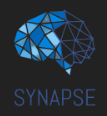

Yay, you made it to Week 2 of NLP! Last time we dealt with various ways to represent text numerically, this week we will dive into various deep learning algorithms specifically suited for NLP related applications.

An article covering multiple deep learning approaches utilised in NLP - https://medium.com/dair-ai/deep-learning-for-nlp-an-overview-of-recent-trends-d0d8f40a776d

#Create your own Embedding Layer

https://keras.io/api/layers/core_layers/embedding/

Look into what is the diiference between the embeddings we built in the previous task and the ones being built through this layer.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the IMDB dataset again
df = pd.read_csv('/content/drive/MyDrive/datasets/movies.csv')

In [ ]:
#Lemmatizing 50,000 reviews takes a lot of time, so if you are a busybee, run on only 5000 columns
df = df[:5000]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
4995,An interesting slasher film with multiple susp...,negative
4996,i watched this series when it first came out i...,positive
4997,Once again Jet Li brings his charismatic prese...,positive
4998,"I rented this movie, after hearing Chris Gore ...",negative


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import  word_tokenize

lem = WordNetLemmatizer()

In [ ]:
# Dust off the function you used last time to pre-process your data. Remember, the corpus should be a list of list of words
from tqdm import tqdm
stop_words = set(stopwords.words('english'))

def text_transform(df):
  corpus = []
  for rev in tqdm(df):
    rev = re.sub('[^a-zA-Z]', ' ', rev).lower().split()
    rev = [word for word in rev if not word in stop_words]
    corpus.append(rev)
  return corpus

corpus = text_transform(df['review'])

100%|██████████| 5000/5000 [00:00<00:00, 7580.88it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding,Dense,Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

If you read up on Keras' Embedding layer, you know that it converts an indiced representation of your vocabulary into dense embedded vectors which you can feed into subsequent layers. We will use One-Hot representation to create this index. The one-hot library on the input vocabulary size returns an array of integers ranging from 1 to vocabulary size. It indicates the index of the '1' in the one hot representation for the word.

In [ ]:
#Find vocabulary count of your corpus
#code
vocabulary = set()
for sen in corpus:
        for word in sen:
            vocabulary.add(word)
len(vocabulary)

38345

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/one_hot

In [ ]:
#Look into what format the one_hot library requires and accordingly fill data in OH_rep
OH_rep = []
vocab_count=len(vocabulary)
for sen in corpus:
    sentence_encoding = []
    for word in sen:
        sentence_encoding.extend(one_hot(word, vocab_count))
    OH_rep.append(sentence_encoding)

In [ ]:
len(OH_rep)

5000

In [ ]:
# Padding: 2 types: pre padding, post padding - try both
# Wisely select the sentence length to accomodate all sentences with a couple of extra bits to avoid errors.
# Add your code here

max_len = max([len(sentence) for sentence in OH_rep])
pre_pad = pad_sequences(OH_rep, maxlen=max_len, padding='pre', truncating='pre')
print(pre_pad[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In case you're still confused by Keras' Sequential Model - https://youtu.be/VGCHcgmZu24?si=ntdywfeqCcAjWWqZ

Lets make a custom Embedding Layer now.

In [ ]:
class CustomEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(CustomEmbeddingLayer, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        # Initialize the embedding matrix with random values
        self.embedding_matrix = self.add_weight(name="embedding_matrix",
                                               shape=(self.vocab_size, self.embed_dim),
                                               initializer="random_normal",
                                               trainable=True)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.int32)
        # Map integer indices to embedding vectors
        return tf.nn.embedding_lookup(self.embedding_matrix, inputs)

    def compute_output_shape(self, input_shape):
        return input_shape + (self.embed_dim,)

In [ ]:
# select your feature dimensions: 5 for very small datasets, 10 is generally a good choice
dim=10

In [ ]:
# Create a sequential model with the custom embedding layer along with the appropriate vocabulary size and the decided dimension size.
# Remember to add a Flatten layer to convert the input from 3D to 2D, and a final Dense layer.
#Your code here

model = Sequential()
model.add(CustomEmbeddingLayer(vocab_count, dim))
model.add(Flatten())
model.add(Dense(1, activation='softmax'))

In [ ]:
#Compile the model with optimizer adam and loss mse
# Code here
model.compile(optimizer='adam', loss='mse')

In [ ]:
y=pd.get_dummies(df['sentiment'])
y=y.iloc[:,1].values

In [ ]:
#Split the dataset into train,test dataset
#Code here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pre_pad, y, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train,y_train, epochs=10, verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


125/125 - 2s - 14ms/step - loss: 0.5005
Epoch 2/10
125/125 - 0s - 2ms/step - loss: 0.5005
Epoch 3/10
125/125 - 0s - 2ms/step - loss: 0.5005
Epoch 4/10
125/125 - 0s - 2ms/step - loss: 0.5005
Epoch 5/10
125/125 - 0s - 2ms/step - loss: 0.5005
Epoch 6/10
125/125 - 0s - 2ms/step - loss: 0.5005
Epoch 7/10
125/125 - 0s - 2ms/step - loss: 0.5005
Epoch 8/10
125/125 - 0s - 2ms/step - loss: 0.5005
Epoch 9/10
125/125 - 0s - 2ms/step - loss: 0.5005
Epoch 10/10
125/125 - 0s - 2ms/step - loss: 0.5005


In [ ]:
model.evaluate(X_test,y_test,verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


32/32 - 1s - 17ms/step - loss: 0.5300


0.5299999713897705

Now that you tried out your own embedding layer, use Keras' inbuilt Embedding layer and run your model again. Are the accuracies comparable?

#Text Generation using LSTM

LSTM Networks are used for a wide variety of purposes ranging from sentiment analysis to time series analysis, but one of its most interesting applications is text generation, which has tremendous application. All Large Language Models like GPT essentially perform is text generation, where they complete your prompt with a response deemed most appropriate to complete the prompt.

But let's back up a bit. If you didn't know, what is an LSTM Network?
Rewatch these videos -
https://youtu.be/WCUNPb-5EYI?si=4URnZuUdGkMwNmTY

https://youtu.be/YCzL96nL7j0?si=iHYqMXEV9VF1q9x2



Hopefully you can now appreciate how an LSTM is well suited to handle the challenge of text generation. Actually, wait, explain to me how LSTM's are suited to handle this task and capture context.

Your answer here (COMPULSORY)

In [ ]:
from tensorflow.keras.layers import LSTM

Now a question arises, what are we exactly generating? It would be foolish to assume the model just spits out a fully formed block of text. We can predict either the next character of next word in a sequence, and keep doing so until we have a block of text.

Which method is better, you ask?

https://medium.com/@john.l.tauscher/word-vs-character-text-generation-80a6dbba123a#:~:text=So%2C%20for%20a%20character%20generative,below%2C%20I%20had%2012%2C700%20inputs.

For this task, we will proceed with word generation.

We need a dataset for the model to learn how to generate text, and for that we're going to pick up the very wonderful book Alice In Wonderland by Lewis Caroll. Thanks, Lewis.

https://drive.google.com/file/d/1QOcIEov-jZqiJ6K7oDnaWup81Q7l_Ji3/view?usp=drive_link

In [ ]:
# Load your text data
file_path = '/content/drive/MyDrive/datasets/aliceinwonderland.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

In [ ]:
# Tokenize the text. Use Tokenizer provided by Keras and fit the text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts([text])
#code here
vocabulary = vocabulary = len(tokenizer.word_index) + 1 #no of words in tokenizer + 1

Now, instead of just passing complete sentences into our model, we will pass n-grams of increasing length which predicts the next word. As a result, the last n-gram of a sentence consists mostly of words which have been predicted by earlier n-grams. This image should make it clearer -

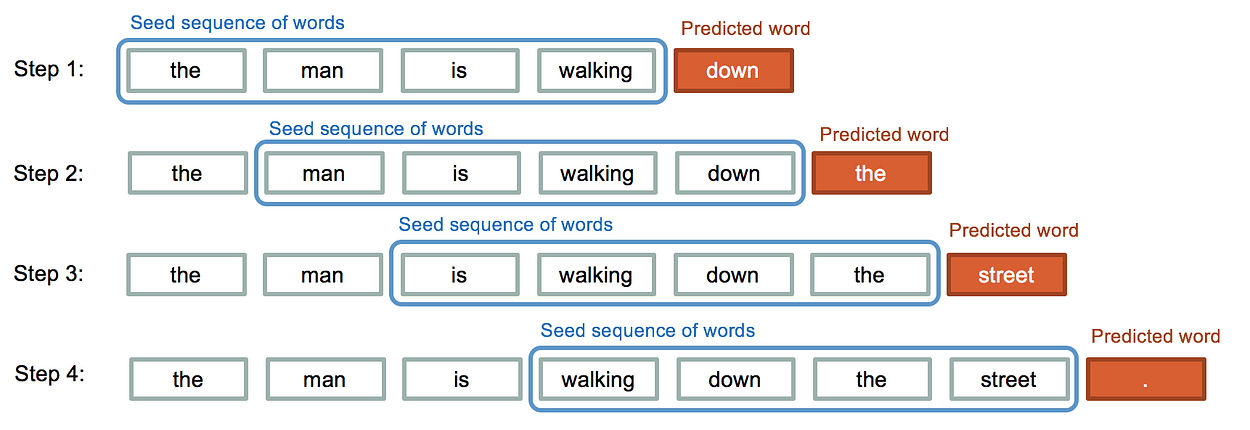

In [ ]:
# Convert text to sequences
input_sequences = []
for line in text.split('\n'):
    #use tokenizer.sequences_to_lists to convert your text into tokens and create a list called token_list
    #create n-grams with length 1,2,3....upto length of token_list and append to input_sequences (Include the word to be predicted)
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

The input_sequences list you got has n-grams of variable length, which isin't very good for training, so we pad the sequences to make them equal in length.

In [ ]:
# Pad sequences for equal length
max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

In [ ]:
# Create predictors and labels
X, y = input_sequences[:,:-1],input_sequences[:,-1] #X is sequence of words except the last word, y is the word to be predicted
y = tf.keras.utils.to_categorical(y, num_classes=vocabulary) #Use to_categorical function of Keras to convert target words

In [ ]:
#Create a sequential model with an Embedding layer with vocabulary, dimensions, and input_length as parameters, an LSTM with 100 units, and a Dense layer with softmax activation
model = Sequential()
model.add(Embedding(vocabulary, 10))
model.add(LSTM(100))
model.add(Dense(vocabulary, activation='softmax'))

model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(X, y, epochs=50,verbose=2) # increase the number of epochs for better accuracy, decrease for reducing time

Epoch 1/50
790/790 - 11s - 14ms/step - accuracy: 0.0515 - loss: 3.2647e-04
Epoch 2/50
790/790 - 4s - 4ms/step - accuracy: 0.0592 - loss: 3.2647e-04
Epoch 3/50
790/790 - 6s - 8ms/step - accuracy: 0.0592 - loss: 3.2647e-04
Epoch 4/50
790/790 - 4s - 5ms/step - accuracy: 0.0592 - loss: 3.2646e-04
Epoch 5/50
790/790 - 5s - 6ms/step - accuracy: 0.0592 - loss: 3.2646e-04
Epoch 6/50
790/790 - 6s - 7ms/step - accuracy: 0.0592 - loss: 3.2644e-04
Epoch 7/50
790/790 - 4s - 5ms/step - accuracy: 0.0592 - loss: 3.2586e-04
Epoch 8/50
790/790 - 6s - 7ms/step - accuracy: 0.0574 - loss: 3.2402e-04
Epoch 9/50
790/790 - 4s - 5ms/step - accuracy: 0.0589 - loss: 3.2350e-04
Epoch 10/50
790/790 - 4s - 4ms/step - accuracy: 0.0592 - loss: 3.2334e-04
Epoch 11/50
790/790 - 6s - 7ms/step - accuracy: 0.0592 - loss: 3.2312e-04
Epoch 12/50
790/790 - 4s - 6ms/step - accuracy: 0.0596 - loss: 3.2233e-04
Epoch 13/50
790/790 - 4s - 5ms/step - accuracy: 0.0668 - loss: 3.2107e-04
Epoch 14/50
790/790 - 6s - 8ms/step - accurac

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]  # Convert seed_text into tokens
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')  # Perform prepadding on text
        predicted_probs = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted_probs, axis=-1)[0] # return index of max probability value from the predictions

        output_word = ""
        #Search through the index list of your tokenizer (word_index) and if it matches the predicted index, save it as output_word and break
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        seed_text += " " + output_word
    return seed_text

# Generate text
generated_text = generate_text("Alice was", 20, model, max_sequence_length)
print(generated_text)

Alice was not to be at her she had not to her little on and in a little of in a little


Hey, not bad! There is some coherence in outputted text which matches the style of the input text. Now its your turn to try and make the output make more sense by improving the model. Add more layers, increase the epochs, use a bigger dataset, play around with it! For example, you can load a document which has all the works of shakespeare and see how the output changes.

Do you now have some more respect for poor ChatGPT, which spits highly coherent and verbose sentences in the blink of an eye? Imagine how much training went into that.

Well, if you look at it closely, we're kinda cheating (but not really) by having words in our tokenizer since our model always defaults to a word in the vocab and shows some coherence. If you really wanna get wild, try out character generation and get coherent outputs from that -

https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

Starting out, obviously you get a lot of random character wishwash, but many many iterations in, you can see the model truly attempt to capture the word style of the original document.

# Question Answering using RNN




First things first, what are RNN's ?

https://www.youtube.com/watch?v=UNmqTiOnRfg

https://www.youtube.com/watch?v=OuYtk9Ymut4

For the adventurous people who need a challenge in life

https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

So everybody's heard about Sentiment Analysis. We are NOT going to do that here. Well, not in its rudimentary way. For a sentence which we know is positive, the question would essentially be, what part of the sentence is positive, and given the sentence as context, the answer gives you the part of the sentence which caused it to be positive. All possible through the power of RNN's. Let's start.

https://drive.google.com/file/d/1tR82E9MmUpTUdJzrng8z1iVgBlBiX08A/view?usp=drive_link

In [ ]:
# write code to load the dataset
df2 = pd.read_csv('/content/drive/MyDrive/datasets/ques_ans.csv')
df2.dropna(inplace=True)
df2.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
context_tokenizer = tf.keras.preprocessing.text.Tokenizer()
#Fit your tokenizer on the text column
context_tokenizer.fit_on_texts(df2['text'])

context = context_tokenizer.texts_to_sequences(df2['text']) # Convert texts to sequences with the tokenizer for text column

answers = context_tokenizer.texts_to_sequences(df2['selected_text']) # Convert texts to sequences with the tokenizer for the selected_text column

#Finding the beginning and ending position of the answer in the context list
beg_pos = [[1 if a[x:x+len(b)] == b else 0 for x in range(len(a))] for a, b in zip(context, answers)]
end_pos = [[1 if a[x:x+len(b)] == b else 0 for x in range(len(a))] for a, b in zip(context, answers)]

In [ ]:
context = np.array(pad_sequences(context, maxlen=36, padding='post', truncating='post'))
#Do the same for beg_pos and end_pos
beg_pos = np.array(pad_sequences(beg_pos, maxlen=36, padding='post', truncating='post'))
end_pos = np.array(pad_sequences(end_pos, maxlen=36, padding='post', truncating='post'))

# Using numpy, check for rows in 'beg_pos' where all elements are zero
zero_rows = np.where(np.all(beg_pos == 0, axis=1))[0]

# Filter out rows in the arrays context, beg_pos, and end_pos where 'beg_pos' is all zero
context = np.delete(context, zero_rows, axis=0)
beg_pos = np.delete(beg_pos, zero_rows, axis=0)
end_pos = np.delete(end_pos, zero_rows, axis=0)

# Add a new axis to 'beg_pos' and 'end_pos'
beg_pos = np.expand_dims(beg_pos, axis=2)
end_pos = np.expand_dims(end_pos, axis=2)

# Concatenate 'beg_pos' and 'end_pos' along the third axis, creating a 3D array
ans_vec = np.concatenate((beg_pos, end_pos), axis=2)

context.shape, beg_pos.shape, end_pos.shape, ans_vec.shape

((26235, 36), (26235, 36, 1), (26235, 36, 1), (26235, 36, 2))

In [ ]:
question_tokenizer = tf.keras.preprocessing.text.Tokenizer()
question_tokenizer.fit_on_texts(df2.sentiment)
question = question_tokenizer.texts_to_sequences(df2.sentiment)

# write code to pad sequences for question, like in the previous cell
question = pad_sequences(question, maxlen=36, padding='post', truncating='post')

# Filter out rows in the question array where 'beg_pos' is all zero
question = np.delete(question, zero_rows, axis=0)

question.shape

(26235, 36)

In [ ]:
# perform train test split on context, question and ans_vec and print its shape

context_train, context_test, question_train, question_test, ans_vec_train, ans_vec_test = train_test_split(context, question, ans_vec, test_size=0.2, random_state=42)

context_train.shape, context_test.shape, question_train.shape, question_test.shape, ans_vec_train.shape, ans_vec_test.shape

((20988, 36),
 (5247, 36),
 (20988, 36),
 (5247, 36),
 (20988, 36, 2),
 (5247, 36, 2))

https://keras.io/api/layers/merging_layers/concatenate/

GRU(Gated Recurrent Units) - https://youtu.be/tOuXgORsXJ4?si=BG9l-HXTijxaovHO

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context (InputLayer)      │ (None, 36)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question (InputLayer)     │ (None, 36)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context_embeddings        │ (None, 36, 64)         │      1,702,336 │ context[0][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question_embeddings       │ (None, 36, 64)         │            256 │ question[0][0]         │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context_gru (GRU)         │ (None, 36, 64)         │         24,960 │ context_embeddings[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question_gru (GRU)        │ (None, 36, 64)         │         24,960 │ question_embeddings[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ merged_embeddings         │ (None, 36, 128)        │              0 │ context_gru[0][0],     │
│ (Concatenate)             │                        │                │ question_gru[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 36, 2)          │            258 │ merged_embeddings[0][… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,752,770 (6.69 MB)

 Trainable params: 1,752,770 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

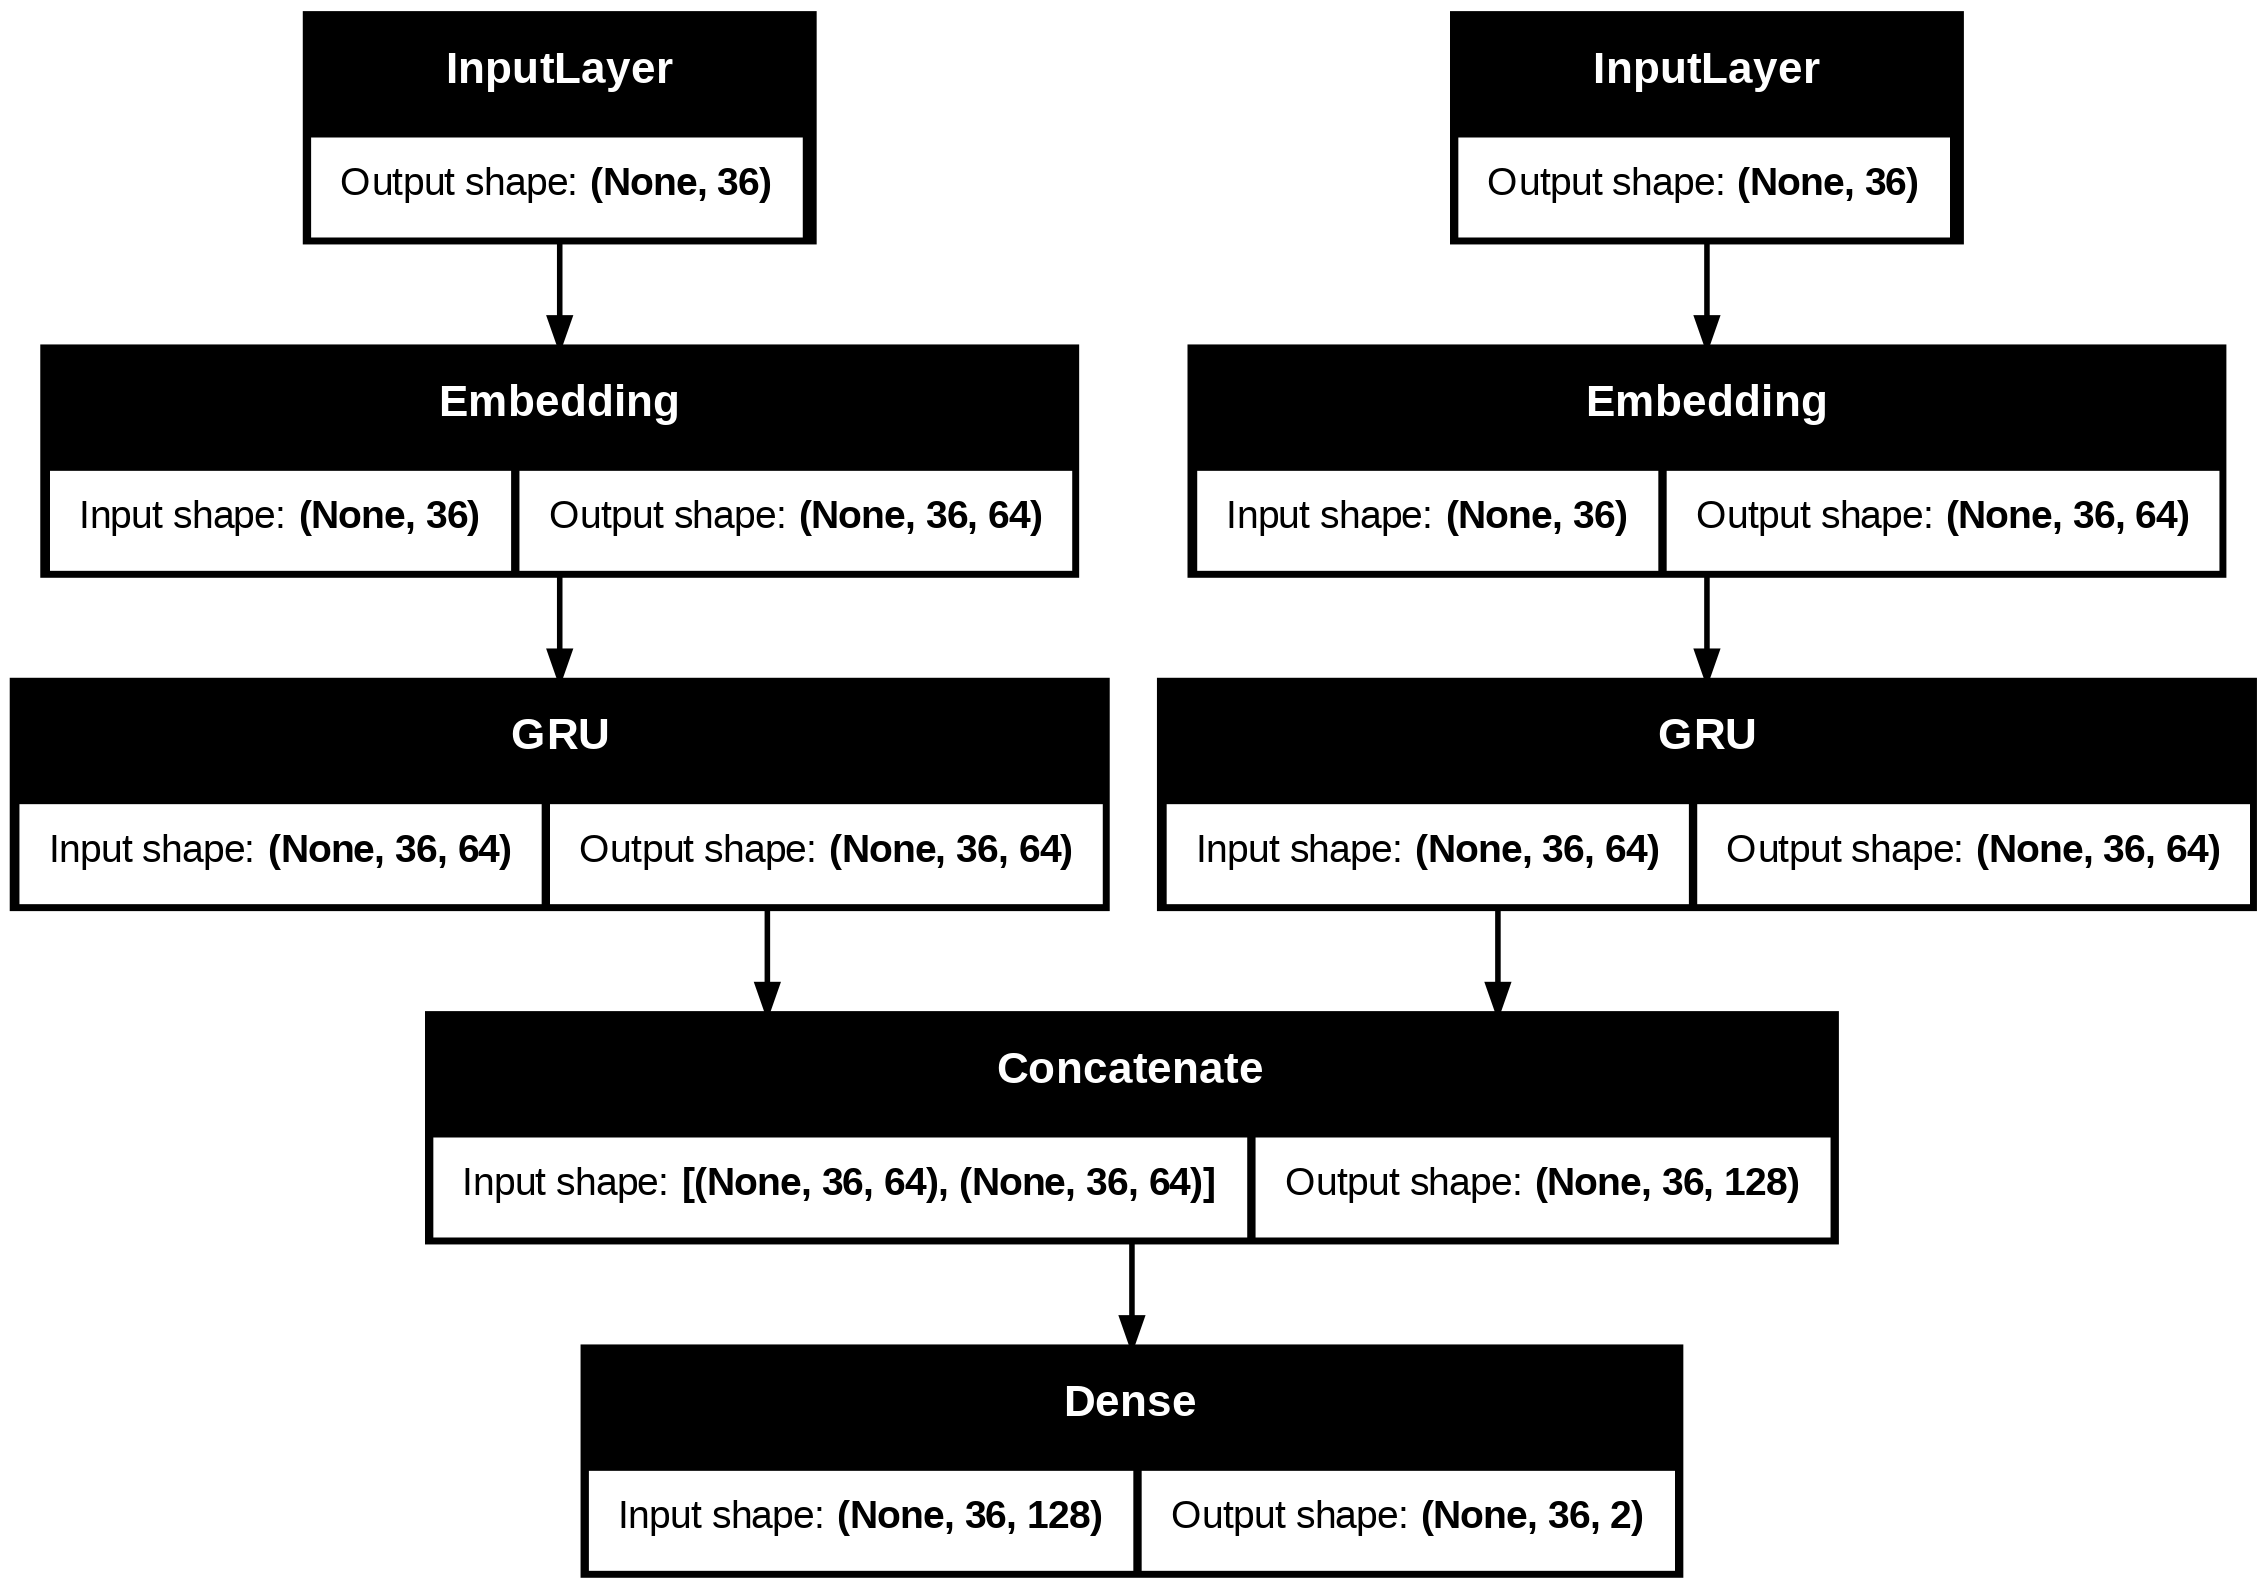

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers as L

EMBED_DIM = 64
N_REC = 64

# create input layers for context_inp and question_input. Name it context and question
context = keras.Input(shape=(context_train.shape[1],), name='context')
question = keras.Input(shape=(question_train.shape[1],), name='question')

context_emb = L.Embedding(len(context_tokenizer.word_index)+1, EMBED_DIM, name='context_embeddings')(context)
question_emb = L.Embedding(len(question_tokenizer.word_index)+1, EMBED_DIM, name='question_embeddings')(question)

# create GRU layers for context_emb and question_emb, keep return_sequences = True
context_gru = L.GRU(N_REC, return_sequences=True, name='context_gru')(context_emb)
question_gru = L.GRU(N_REC, return_sequences=True, name='question_gru')(question_emb)

#write code to concatenate these 2 embedding layers, and create a Dense layer for the output
merged_emb = L.concatenate([context_gru, question_gru], axis=2, name='merged_embeddings')
output = L.Dense(2, activation='softmax', name='output')(merged_emb)

model = keras.Model(inputs=[context, question], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-4))
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)

# fit the model with train data for [context, question] and ans_vec, and similarly write code for validation data, store it in a variable named 'history'
# do not forget to keep the number of epochs as 25 and the callbacks as es and rlp

history = model.fit(
    [context_train, question_train],
    ans_vec_train,
    epochs=25,
    batch_size=32,
    validation_data=([context_test, question_test], ans_vec_test),
    callbacks=[es, rlp]
)

Epoch 1/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.2127 - val_loss: 0.0704 - learning_rate: 1.0000e-04
Epoch 2/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0683 - val_loss: 0.0628 - learning_rate: 1.0000e-04
Epoch 3/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0606 - val_loss: 0.0563 - learning_rate: 1.0000e-04
Epoch 4/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0541 - val_loss: 0.0527 - learning_rate: 1.0000e-04
Epoch 5/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0511 - val_loss: 0.0506 - learning_rate: 1.0000e-04
Epoch 6/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0471 - val_loss: 0.0491 - learning_rate: 1.0000e-04
Epoch 7/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0467 - val_loss: 0.0486 - learning_rate: 1.0000e-04
Epoch 8/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0439 - val_loss: 0.0484 - learning_rate: 1.0000e-04
Epoch 9/25
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0436 - val_loss: 0

In [ ]:
idx = 28
context_valid, question_valid, ans_vec_valid = context_test, question_test, ans_vec_test
query_context = context_valid[idx:idx+1]
query_question = question_valid[idx:idx+1]
query_ans_vec = ans_vec_valid[idx:idx+1]
query_ans_beg, query_ans_end  = np.ravel(ans_vec_valid[idx:idx+1].argmax(axis=1))  #Look into what this does
print('Context:', context_tokenizer.sequences_to_texts(query_context))
print('Question:', question_tokenizer.sequences_to_texts(query_question))
print('Answer:', context_tokenizer.sequences_to_texts([query_context[0][query_ans_beg: query_ans_end+1]]))
pred_ans_beg, pred_ans_end = np.ravel(model([query_context, query_question]).numpy().argmax(axis=1))
print('Predicted Answer:', context_tokenizer.sequences_to_texts([query_context[0][pred_ans_beg: pred_ans_end+1]]))

Context: ['and i want to let you know im here for vfc no matter what happens and yes i need a hug to bad i live in delaware']
Question: ['negative']
Answer: ['i']
Predicted Answer: ['to let you know im here for vfc no matter what happens and yes i need a hug to bad i live in delaware']


Just for fun, here is a cell to put custom inputs and predict which part of the sentence matches the question you input.

In [ ]:
def predict_custom_input(custom_context, custom_question):
    # Tokenize and preprocess the custom input
    custom_context_seq = context_tokenizer.texts_to_sequences([custom_context])
    custom_context_padded = np.array(pad_sequences(custom_context_seq, maxlen=36, padding='post', truncating='post'))

    custom_question_seq = question_tokenizer.texts_to_sequences([custom_question])
    custom_question_padded = np.array(pad_sequences(custom_question_seq, maxlen=36, padding='post', truncating='post'))

    # Make predictions using the trained model
    predictions = model.predict([custom_context_padded, custom_question_padded])

    # Extract predicted answer indices
    pred_ans_beg, pred_ans_end = np.ravel(predictions.argmax(axis=1))

    # Convert indices to text
    pred_answer_text = context_tokenizer.sequences_to_texts([custom_context_padded[0][pred_ans_beg: pred_ans_end+1]])

    # Print the results
    print('Custom Input:')
    print('Context:', custom_context)
    print('Question:', custom_question)
    print('Predicted Answer:', pred_answer_text)

# Example usage:
custom_context_input = input("Your custom context goes here.")
custom_question_input = input("Your custom question goes here.")
predict_custom_input(custom_context_input, custom_question_input)


# <font color='#4879E2'>More resources</font>

Yoav Goldberg's book [Neural Network Methods for Natural Language Processing](http://www.morganclaypool.com/doi/abs/10.2200/S00762ED1V01Y201703HLT037) is a thorough introduction to neural networks for NLP tasks in general.

If you'd like to learn more about what Keras is doing under the hood, there is a [Theano tutorial](http://deeplearning.net/tutorial/lstm.html) that also applies an RNN to sentiment prediction, using the same dataset here

Andrej Karpathy's blog post [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) is very helpful for understanding the mathematical details of an RNN, applied to the task of language modeling. It also provides raw Python code with an implementation of the backpropagation algorithm.

TensorFlow also has an RNN language model [tutorial](https://www.tensorflow.org/versions/r0.12/tutorials/recurrent/index.html) using the Penn Treebank dataset

Chris Olah provides a good [explanation](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) of how LSTM RNNs work (this explanation also applies to the GRU model used here)

Denny Britz's [tutorial](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) documents well both the technical details of RNNs and their implementation in Python.

#Research Task

Look into how Name Entity Recognition and Parts of Speech Tagging work and show your research for the same.